# Generating Images for Tuple Systems

## Initializations

In [1]:
%pylab inline 
from bigfile import BigFile  
import seaborn as sns
import scipy.interpolate as interpolate
from matplotlib.colors import ListedColormap

from scipy import integrate
from gaepsi2 import painter
from gaepsi2 import color
from gaepsi2 import camera
from scipy.spatial import cKDTree as KDTree

import matplotlib.patches as patches

import pickle

import import_ipynb
import Tuples_Information as tuples

Populating the interactive namespace from numpy and matplotlib
importing Jupyter notebook from Tuples Information.ipynb


In [2]:
import warnings
warnings.filterwarnings("ignore")

sns.set_palette(sns.set_style("white"),\
                sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in"}))

In [3]:
plt.rcParams['axes.linewidth'] = 1.8 #set the value globally
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 18
plt.rc('xtick', labelsize=17)    # fontsize of the tick labels
plt.rc('ytick', labelsize=17) 

In [4]:
import matplotlib as mpl
class MplColorHelper:
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = mpl.cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)

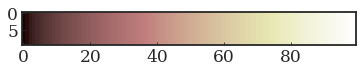

In [5]:
y = np.linspace(0,1,100)
COL = MplColorHelper('pink', 0, 1)

x = COL.get_rgb(y)
starmap = color.Colormap(x[:,0:3])

#----
z = np.expand_dims(x,axis=0)
z = np.repeat(z,10,axis=0)
plt.imshow(z)

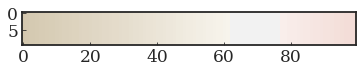

In [6]:
class MplColorHelper2:
    def __init__(self, cmap, start_val, stop_val):
        self.cmap = cmap
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = mpl.cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)
    
y = np.linspace(0,1,100)
COL = MplColorHelper2(sns.diverging_palette(60, 20, as_cmap=True), -1.2, 2.6)
x = COL.get_rgb(y)
starmap = color.Colormap(x[:,0:3])
z = np.expand_dims(x,axis=0)
z = np.repeat(z,10,axis=0)
plt.imshow(z)

In [7]:
hh = 0.697

fac = 121.14740013761634  # GADGET unit Protonmass / Bolztman const
GAMMA = 5 / 3.
Xh=0.76

Mpc_to_km=3.086e+19
sec_to_megayr=3.17098e-8 # convert to years

omk=0
oml=0.7186
omm=0.2814
h=hh=0.697

def E(a): #normalized hubble parameter
    return np.sqrt(omm*(a)**(-3)+oml)

def integrand(a):
    return 1.0/(a*E(a))

def age(a0,a1):
    return 1./(h*100.0)*integrate.quad(integrand,a0,a1)[0]

def smooth(pos):
    tree = KDTree(pos)
    d, i = tree.query(pos,k=60)
    return d[:,-1].copy()

In [8]:
def inertia(pos,mass):  # pos in [[x1,x2..],[y1,y2..],[z1,z2..]]
    g11=np.sum((pos[1]*pos[1]+pos[2]*pos[2])*mass)
    g22=np.sum((pos[0]*pos[0]+pos[2]*pos[2])*mass)
    g33=np.sum((pos[0]*pos[0]+pos[1]*pos[1])*mass)
    g12=-np.sum(pos[0]*pos[1]*mass)
    g13=-np.sum(pos[0]*pos[2]*mass)
    g23=-np.sum(pos[1]*pos[2]*mass)
    g21=g12
    g31=g13
    g32=g23
    mx = np.array([[g11,g12,g13],[g21,g22,g23],[g31,g32,g33]])/np.sum(mass)
    w, v = np.linalg.eig(mx)
    v = v[:, np.abs(w).argsort()] # column v[:,i] is the eigenvector corresponding to the eigenvalue w[i]
    return v                      # return Imom eigenvector with eigenvalue from smallest to largest

def face_on_3rotate(dr,mass,th=-1): # p in [[x1,y1,z1],[x2,y2,z2],...]
    rr = np.linalg.norm(dr,axis=1)
    if th>0:
        mask = rr<th
    else:
        mask = rr>0
    v = inertia(np.transpose(dr[mask]),mass[mask])
#     print (v)
    xnew = np.einsum('ij,j->i', dr, v[:,0])
    ynew = np.einsum('ij,j->i', dr, v[:,1])
    znew = np.einsum('ij,j->i', dr, v[:,2])
    newpos = np.transpose(np.array([xnew,ynew,znew]))
    return newpos

def edge_on_3rotate(dr,mass,th=-1): # p in [[x1,y1,z1],[x2,y2,z2],...]
    rr = np.linalg.norm(dr,axis=1)
    if th>0:
        mask = rr<th
    else:
        mask = rr>0
    v = inertia(np.transpose(dr[mask]),mass[mask])
#     print ("rotate axis:",v)
    xnew = np.einsum('ij,j->i', dr, v[:,1])
    ynew = np.einsum('ij,j->i', dr, v[:,2])
    znew = np.einsum('ij,j->i', dr, v[:,0])
    newpos = np.transpose(np.array([xnew,ynew,znew]))
    return newpos

In [9]:
def place(number, offarray):   # offarray is sorted from smallest to largest 
    dummy = np.where(offarray <= number)[0]
    return dummy[-1]

In [10]:
path = '/hildafs/datasets/Asterix/BH_details_dict/Read-Blackhole-Detail'
detail = BigFile(path)
AllIDs = detail.open('BHID')[:]
Index = detail.open('Index')[:]

In [11]:
outdir = '/hildafs/datasets/Asterix/BH_details_dict/'

In [12]:
triples_z3_dr30 = tuples.triples_z3_dr30
triples_z3_dr200 = tuples.triples_z3_dr200
quadruples_z3_dr30 = tuples.quadruples_z3_dr30
quadruples_z3_dr200 = tuples.quadruples_z3_dr200

In [13]:
triples_z2_dr30 = tuples.triples_z2_dr30
triples_z2_dr200 = tuples.triples_z2_dr200
quadruples_z2_dr30 = tuples.quadruples_z2_dr30
quadruples_z2_dr200 = tuples.quadruples_z2_dr200

In [14]:
def triple_idx (trips):
    length = len (trips)
    ret_val = []
    
    BH_IDs = pig.open('5/ID')[:1000000]
    
    for i in range (length):
        curr = trips[i]
        
        idx1 = (BH_IDs == curr[0]).nonzero()[0][0]
        idx2 = (BH_IDs == curr[1]).nonzero()[0][0]
        idx3 = (BH_IDs == curr[2]).nonzero()[0][0]
        
        ret_val.append([idx1, idx2, idx3])
        
    return ret_val

In [15]:
def trip_com (tripindex):
    bh1idx = tripindex[0]
    bh2idx = tripindex[1]
    bh3idx = tripindex[2]
    
    bh1pos = pig.open('5/Position')[bh1idx]
    bh2pos = pig.open('5/Position')[bh2idx]
    bh3pos = pig.open('5/Position')[bh3idx]
    
    bh1mass = pig.open('5/BlackholeMass')[bh1idx]
    bh2mass = pig.open('5/BlackholeMass')[bh2idx]
    bh3mass = pig.open('5/BlackholeMass')[bh3idx]
    
    totmass = bh1mass + bh2mass + bh3mass
    
    xcm = ((bh1mass * bh1pos[0]) + (bh2mass * bh2pos[0]) + (bh3mass * bh3pos[0])) / totmass
    ycm = ((bh1mass * bh1pos[1]) + (bh2mass * bh2pos[1]) + (bh3mass * bh3pos[1])) / totmass
    zcm = ((bh1mass * bh1pos[2]) + (bh2mass * bh2pos[2]) + (bh3mass * bh3pos[2])) / totmass
    
    return array([xcm, ycm, zcm])

In [16]:
def extract_host_galaxies_triples(pig,frame,trip,tripindex,groupindex,crop=20,orientation='None',ort_radius=-1):
    redshift = 1./pig.open('Header').attrs['Time']-1
    # print ("z = ",redshift)
    
    a_cur=1./(1.+redshift)
    SFT_space=np.linspace(0,a_cur[0],500)
    age_space=[age(SFT,1./(1.+redshift))*Mpc_to_km*sec_to_megayr for SFT in SFT_space]  # age in year
    gen_SFT_to_age=interpolate.interp1d(SFT_space,age_space,fill_value='extrapolate')
    
    bh1idx = tripindex[0]
    bh2idx = tripindex[1]
    bh3idx = tripindex[2]
    
    bh1pos = pig.open('5/Position')[bh1idx]
    bh2pos = pig.open('5/Position')[bh2idx]
    bh3pos = pig.open('5/Position')[bh3idx]
    # print ("bh position:", bhpos)
    
    COMpos = _
    if frame != '214':
        COMpos = trip_com (tripindex)
    else:
        COMpos = trip_com_214 (triple_idx_214([trip])[0])
    
    BHLength = pig.open('FOFGroups/LengthByType')[0:10000]
    off = np.cumsum(BHLength,axis=0)
    a1 = np.array([[0,0,0,0,0,0]],dtype=np.uint64)
    off = np.append(a1,off,axis=0)    # This is OffsetByType of FOF group
    
    staroff = np.transpose(off[groupindex:groupindex+2])[4]
 
    #######################################################################################
    
    pos4 = pig.open('4/Position')[staroff[0]:staroff[1]]
    ppos = pos4 - COMpos
    
    # crop was originally 20; trips defined by separation of 30 kpc, start with crop = 30
    
    mask = np.abs(ppos[:,0]) < crop
    mask &= np.abs(ppos[:,1]) < crop
    mask &= np.abs(ppos[:,2]) < crop
    
    ppos = ppos[mask]
    
    m4 = pig.open('4/Mass')[staroff[0]:staroff[1]][mask]
    st = pig.open('4/StarFormationTime')[staroff[0]:staroff[1]][mask]
    star_age = gen_SFT_to_age(st)/1e6 # in Myr
    # print ("numer of stars:",len(m4))
    mstar = np.sum(m4)*1e10/hh
    # print ("stellar mass = %.2e"%mstar)
    
    if orientation is 'face_on':
        ppos = face_on_3rotate(ppos,m4,th=ort_radius)            
        
    if orientation is 'edge_on':
        ppos = edge_on_3rotate(ppos,m4,th=ort_radius)
    
    sml = smooth(ppos)  
    sml *= 1.6
    
    sml[sml>2] = 2
    # sml = np.ones(len(m4))*0.9
    
    #######################################################################################
    
    lbox = 2*crop
    # resolution = 0.12
    resolution = 0.6
    imsize = int(lbox/resolution)
    # print (imsize)
    if imsize>5000:
        imsize=5000

    ct = lbox/2

    mpers = camera.ortho(-lbox,lbox,(-ct,ct,-ct,ct))  # (near,far,(left,right,top,bottom)),return 4*4 projectionmatrix
    mmv = camera.lookat((0,0,2*lbox),(0,0,0),(1,0,0)) # (position of camera, focal point, up direction)
    star2d = camera.apply(camera.matrix(mpers,mmv),ppos) # apply a camera matrix to data coordinates, return position in clip coordinate
    stardev = camera.todevice(star2d, extent=(imsize, imsize)) # Convert clipping coordinate to device coordinate

    psml = sml/resolution
    psml[psml<1]=1
    
    channels = painter.paint(stardev, psml, [m4,m4*star_age], (imsize, imsize), np=8)
    channels[1] /= channels[0]
    
    return channels,mstar

In [17]:
def plot_trip(ax,trip,Lb,frame='COM'):
    tripidx = triple_idx([trip])[0]
    grpidx = place(tripidx[0],bhoff)
    # print ("groupindex:",grpidx)
    
    
    if frame == 'COM':
        COMpos = trip_com (tripidx)
        # print ("system com:",COMpos)
    
    sysm = 0
    
    redshift = 1./battr["Time"][0] - 1
    
    masses = []
    
    massive = 0
    
    for bidx in tripidx:
        bhm = pig.open('5/BlackholeMass')[bidx]*1e10/hh
        sysm += bhm
        masses.append(bhm)
        # print ("bh mass = %.2e"%bhm)
        bhpos = pig.open('5/Position')[bidx]
        
        if frame != 'COM' and bhm > massive:
            massive = bhm
            COMpos = bhpos
        # print ("bh pos = ",bhpos)
    
    # print("Triple:",trip)
    # print("BH Mass:",masses)
    
    #if redshift > 3.25:
    #    Lb = 250
    #else:
    #    Lb = 150
    crop1 = Lb/2
    channels,mstar = extract_host_galaxies_triples(pig,frame,trip,tripindex=tripidx,groupindex=grpidx,crop=crop1,ort_radius=4)
    vmin0,vmax0 = np.log10(np.percentile(channels[0],30)),np.log10(np.percentile(channels[0],99))
    # vmin1,vmax1 = (np.percentile(np.nan_to_num(channels[1]),30)),(np.percentile(np.nan_to_num(channels[1]),99))    
    img1 = starmap(color.NL(channels[1], range=(1,2.8)), color.NL(channels[0], range=(-4.5,vmax0)))
    
    """
    channels,mstar = extract_host_galaxies_triples(pig,tripindex=tripidx,groupindex=grpidx,orientation='edge_on',crop=30,ort_radius=4)
    vmin0,vmax0 = np.log10(np.percentile(channels[0],30)),np.log10(np.percentile(channels[0],99))
    img2 = starmap(color.NL(channels[1], range=(1,2.8)), color.NL(channels[0], range=(-4.5,vmax0)))    
    
    gsize = img1.shape[0]
    gstart,gend = int(gsize*0.3335),int(gsize*0.6665)
    img = np.concatenate([img1,img2[gstart:gend,:]],axis=0)
    """
    img = img1
    
    bh1_id = trip[0]
    bh1_idx = (AllIDs == bh1_id).nonzero()[0][0]
    bh1_chunk = Index[bh1_idx]
    
    bh2_id = trip[1]
    bh2_idx = (AllIDs == bh2_id).nonzero()[0][0]
    bh2_chunk = Index[bh2_idx]
    
    bh3_id = trip[2]
    bh3_idx = (AllIDs == bh3_id).nonzero()[0][0]
    bh3_chunk = Index[bh3_idx]
    
    save1 = outdir+'BlackholeDetails-%04d'%bh1_chunk
    save2 = outdir+'BlackholeDetails-%04d'%bh2_chunk
    save3 = outdir+'BlackholeDetails-%04d'%bh3_chunk

    with open(save1, 'rb') as f:
        data1 = pickle.load(f)
        f.close()

    bh1 = data1[bh1_id]
    
    del data1
    
    with open(save2, 'rb') as f:
        data2 = pickle.load(f)
        f.close()

    bh2 = data2[bh2_id]
    
    del data2
    
    with open(save3, 'rb') as f:
        data3 = pickle.load(f)
        f.close()

    bh3 = data3[bh3_id]
    
    del data3
    
    curr_redshift = 1./pig.open('Header').attrs['Time']-1
    
    mask1 = bh1['z'] >= curr_redshift
    mask1 &= bh1['z'] <= 4.0
    mask2 = bh2['z'] >= curr_redshift
    mask2 &= bh2['z'] <= 4.0
    mask3 = bh3['z'] >= curr_redshift
    mask3 &= bh3['z'] <= 4.0
    
    bh1 = bh1[mask1]
    
    bh1_x = []
    bh1_y = []

    for i in bh1['BHpos']:
        bh1_x.append(i[0])
        bh1_y.append(i[1])
        
    bh2 = bh2[mask2]
    
    bh2_x = []
    bh2_y = []

    for i in bh2['BHpos']:
        bh2_x.append(i[0])
        bh2_y.append(i[1])
    
    bh3 = bh3[mask3]
    
    bh3_x = []
    bh3_y = []

    for i in bh3['BHpos']:
        bh3_x.append(i[0])
        bh3_y.append(i[1])
    
    ax.imshow(img,extent=[0,Lb,0,Lb],origin='upper')
    
    # ax.scatter(Lb/2, 0.33*Lb + Lb/2,s=5)
    
    bh1pos = pig.open('5/Position')[tripidx[0]]
    bh2pos = pig.open('5/Position')[tripidx[1]]
    bh3pos = pig.open('5/Position')[tripidx[2]]
    
    # ax.scatter(Lb/2, Lb/2, marker='o', c='r')
    
    ax.scatter((bh1pos[0]-COMpos[0]) + Lb/2, (bh1pos[1]-COMpos[1]) + Lb/2,s=50,marker='x',c='g')
    ax.scatter((bh2pos[0]-COMpos[0]) + Lb/2, (bh2pos[1]-COMpos[1]) + Lb/2,s=50,marker='x',c='b')
    ax.scatter((bh3pos[0]-COMpos[0]) + Lb/2, (bh3pos[1]-COMpos[1]) + Lb/2,s=50,marker='x',c='y')
    
    ax.plot((bh1_x - COMpos[0]) + Lb/2, (bh1_y - COMpos[1]) + Lb/2,c='g')
    ax.plot((bh2_x - COMpos[0]) + Lb/2, (bh2_y - COMpos[1]) + Lb/2,c='b')
    ax.plot((bh3_x - COMpos[0]) + Lb/2, (bh3_y - COMpos[1]) + Lb/2,c='y')
    
    xst = Lb*0.01
    yst = Lb*1.29
    lt = Lb*0.4
    
    # bhm0 = pig.open('5/BlackholeMass')[bidx]*1e10/hh

    # ax.annotate(s='',xy=(xst+lt,yst),xytext=(xst,yst),
    #             arrowprops=dict(arrowstyle='|-|,widthA=0.3,widthB=0.3',color='white',lw=2))
    # ax.text(Lb*0.05,yst-Lb*0.10,'8 ckpc/h',dict(color='white'),size=16)
    redshift = 1./pig.open('Header').attrs['Time']-1
    
    info = r'$z$=%s'%(round(redshift[0],2))
    ax.text(Lb*0.75,Lb*0.9,info,dict(color='white'),size=16)

    tcolor="white"
    info1 = r'$M_{\mathrm{BHx3}}$=%.1e$M_{\odot}$'%sysm
    info2 = r'$M_{*}$ = %.1e$M_{\odot}$'%mstar
    info = info1+info2
    #ax.text(Lb*0.05,Lb*0.15,info1,dict(color=tcolor),size=16)
    #ax.text(Lb*0.05,Lb*0.05,info2,dict(color=tcolor),size=16)
    
    ax.set_xlim(0,Lb)
    ax.set_ylim(0,Lb)
    ax.set_xticks([])
    ax.set_yticks([])

In [18]:
def quadruple_idx (quads):
    length = len (quads)
    ret_val = []
    
    for i in range (length):
        curr = quads[i]
        
        idx1 = (BH_IDs == curr[0]).nonzero()[0][0]
        idx2 = (BH_IDs == curr[1]).nonzero()[0][0]
        idx3 = (BH_IDs == curr[2]).nonzero()[0][0]
        idx4 = (BH_IDs == curr[3]).nonzero()[0][0]
        
        ret_val.append([idx1, idx2, idx3, idx4])
        
    return ret_val

In [19]:
def quad_com (quadindex):
    bh1idx = quadindex[0]
    bh2idx = quadindex[1]
    bh3idx = quadindex[2]
    bh4idx = quadindex[3]
    
    bh1pos = pig.open('5/Position')[bh1idx]
    bh2pos = pig.open('5/Position')[bh2idx]
    bh3pos = pig.open('5/Position')[bh3idx]
    bh4pos = pig.open('5/Position')[bh4idx]
    
    bh1mass = pig.open('5/BlackholeMass')[bh1idx]
    bh2mass = pig.open('5/BlackholeMass')[bh2idx]
    bh3mass = pig.open('5/BlackholeMass')[bh3idx]
    bh4mass = pig.open('5/BlackholeMass')[bh4idx]
    
    totmass = bh1mass + bh2mass + bh3mass + bh4mass
    
    xcm = ((bh1mass * bh1pos[0]) + (bh2mass * bh2pos[0]) + (bh3mass * bh3pos[0]) + (bh4mass * bh4pos[0])) / totmass
    ycm = ((bh1mass * bh1pos[1]) + (bh2mass * bh2pos[1]) + (bh3mass * bh3pos[1]) + (bh4mass * bh4pos[1])) / totmass
    zcm = ((bh1mass * bh1pos[2]) + (bh2mass * bh2pos[2]) + (bh3mass * bh3pos[2]) + (bh4mass * bh4pos[2])) / totmass
    
    return array([xcm, ycm, zcm])

In [20]:
def extract_host_galaxies_quadruples(pig,frame,quad,quadindex,groupindex,crop=20,orientation='None',ort_radius=-1,):
    redshift = 1./pig.open('Header').attrs['Time']-1
    # print ("z = ",redshift)
    
    a_cur=1./(1.+redshift)
    SFT_space=np.linspace(0,a_cur[0],500)
    age_space=[age(SFT,1./(1.+redshift))*Mpc_to_km*sec_to_megayr for SFT in SFT_space]  # age in year
    gen_SFT_to_age=interpolate.interp1d(SFT_space,age_space,fill_value='extrapolate')
    
    bh1idx = quadindex[0]
    bh2idx = quadindex[1]
    bh3idx = quadindex[2]
    bh4idx = quadindex[3]
    
    bh1pos = pig.open('5/Position')[bh1idx]
    bh2pos = pig.open('5/Position')[bh2idx]
    bh3pos = pig.open('5/Position')[bh3idx]
    bh4pos = pig.open('5/Position')[bh4idx]
    # print ("bh position:", bhpos)
    
    COMpos = _
    if frame != '214':
        COMpos = quad_com (quadindex)
    else:
        COMpos = quad_com_214 (quadruple_idx_214([quad])[0])
    
    BHLength = pig.open('FOFGroups/LengthByType')[0:10000]
    off = np.cumsum(BHLength,axis=0)
    a1 = np.array([[0,0,0,0,0,0]],dtype=np.uint64)
    off = np.append(a1,off,axis=0)    # This is OffsetByType of FOF group
    
    staroff = np.transpose(off[groupindex:groupindex+2])[4]
 
    #######################################################################################
    
    pos4 = pig.open('4/Position')[staroff[0]:staroff[1]]
    ppos = pos4 - COMpos
    
    # crop was originally 20; trips defined by separation of 30 kpc, start with crop = 30
    
    mask = np.abs(ppos[:,0]) < crop
    mask &= np.abs(ppos[:,1]) < crop
    mask &= np.abs(ppos[:,2]) < crop
    
    ppos = ppos[mask]
    
    m4 = pig.open('4/Mass')[staroff[0]:staroff[1]][mask]
    st = pig.open('4/StarFormationTime')[staroff[0]:staroff[1]][mask]
    star_age = gen_SFT_to_age(st)/1e6 # in Myr
    # print ("numer of stars:",len(m4))
    mstar = np.sum(m4)*1e10/hh
    # print ("stellar mass = %.2e"%mstar)
    
    if orientation is 'face_on':
        ppos = face_on_3rotate(ppos,m4,th=ort_radius)            
        
    if orientation is 'edge_on':
        ppos = edge_on_3rotate(ppos,m4,th=ort_radius)
    
    sml = smooth(ppos)  
    sml *= 1.6
    
    sml[sml>2] = 2
    # sml = np.ones(len(m4))*0.9
    
    #######################################################################################
    
    lbox = 2*crop
    # resolution = 0.12
    resolution = 0.6
    imsize = int(lbox/resolution)
    # print (imsize)
    if imsize>5000:
        imsize=5000

    ct = lbox/2

    mpers = camera.ortho(-lbox,lbox,(-ct,ct,-ct,ct))  # (near,far,(left,right,top,bottom)),return 4*4 projectionmatrix
    mmv = camera.lookat((0,0,2*lbox),(0,0,0),(1,0,0)) # (position of camera, focal point, up direction)
    star2d = camera.apply(camera.matrix(mpers,mmv),ppos) # apply a camera matrix to data coordinates, return position in clip coordinate
    stardev = camera.todevice(star2d, extent=(imsize, imsize)) # Convert clipping coordinate to device coordinate

    psml = sml/resolution
    psml[psml<1]=1
    
    channels = painter.paint(stardev, psml, [m4,m4*star_age], (imsize, imsize), np=8)
    channels[1] /= channels[0]
    
    return channels,mstar

In [21]:
def plot_quad(ax,quad,Lb,frame='214'):
    quadidx = quadruple_idx([quad])[0]
    grpidx = place(quadidx[0],bhoff)
    # print ("groupindex:",grpidx)
    
    COMpos = _
    if frame != '214':
        COMpos = quad_com (quadidx)
        # print ("system com:",COMpos)
    else:
        COMpos = quad_com_214 (quadruple_idx_214([quad])[0])
        # print ("system com at z = 3.0:",COMpos)
    sysm = 0
    
    for bidx in quadidx:
        bhm = pig.open('5/BlackholeMass')[bidx]*1e10/hh
        sysm += bhm
        # print ("bh mass = %.2e"%bhm)
        bhpos = pig.open('5/Position')[bidx]
        # print ("bh pos = ",bhpos)
        
    # Lb = 150
    crop1 = Lb/2
    channels,mstar = extract_host_galaxies_quadruples(pig,frame,quad,quadindex=quadidx,groupindex=grpidx,crop=crop1,ort_radius=4)
    vmin0,vmax0 = np.log10(np.percentile(channels[0],30)),np.log10(np.percentile(channels[0],99))
    # vmin1,vmax1 = (np.percentile(np.nan_to_num(channels[1]),30)),(np.percentile(np.nan_to_num(channels[1]),99))    
    img1 = starmap(color.NL(channels[1], range=(1,2.8)), color.NL(channels[0], range=(-4.5,vmax0)))
    
    """
    channels,mstar = extract_host_galaxies_quadruples(pig,quadindex=quadidx,groupindex=grpidx,crop=80,ort_radius=4)
    vmin0,vmax0 = np.log10(np.percentile(channels[0],30)),np.log10(np.percentile(channels[0],99))
    img2 = starmap(color.NL(channels[1], range=(1,2.8)), color.NL(channels[0], range=(-4.5,vmax0)))    
    
    
    gsize = img1.shape[0]
    gstart,gend = int(gsize*0.3335),int(gsize*0.6665)
    img = np.concatenate([img1,img2[gstart:gend,:]],axis=0)
    """
    img = img1
    
    bh1_id = quad[0]
    bh1_idx = (AllIDs == bh1_id).nonzero()[0][0]
    bh1_chunk = Index[bh1_idx]
    
    bh2_id = quad[1]
    bh2_idx = (AllIDs == bh2_id).nonzero()[0][0]
    bh2_chunk = Index[bh2_idx]
    
    bh3_id = quad[2]
    bh3_idx = (AllIDs == bh3_id).nonzero()[0][0]
    bh3_chunk = Index[bh3_idx]
    
    bh4_id = quad[3]
    bh4_idx = (AllIDs == bh4_id).nonzero()[0][0]
    bh4_chunk = Index[bh4_idx]
    
    save1 = outdir+'BlackholeDetails-%04d'%bh1_chunk
    save2 = outdir+'BlackholeDetails-%04d'%bh2_chunk
    save3 = outdir+'BlackholeDetails-%04d'%bh3_chunk
    save4 = outdir+'BlackholeDetails-%04d'%bh4_chunk

    with open(save1, 'rb') as f:
        data1 = pickle.load(f)
        f.close()

    bh1 = data1[bh1_id]
    
    del data1
    
    with open(save2, 'rb') as f:
        data2 = pickle.load(f)
        f.close()

    bh2 = data2[bh2_id]
    
    del data2
    
    with open(save3, 'rb') as f:
        data3 = pickle.load(f)
        f.close()

    bh3 = data3[bh3_id]
    
    del data3
    
    with open(save4, 'rb') as f:
        data4 = pickle.load(f)
        f.close()

    bh4 = data4[bh4_id]
    
    del data4
    
    curr_redshift = 1./pig.open('Header').attrs['Time']-1

    mask1 = bh1['z'] > curr_redshift
    mask1 &= bh1['z'] < 4.0
    mask2 = bh2['z'] > curr_redshift
    mask2 &= bh2['z'] < 4.0
    mask3 = bh3['z'] > curr_redshift
    mask3 &= bh3['z'] < 4.0
    mask4 = bh4['z'] > curr_redshift
    mask4 &= bh4['z'] < 4.0
    
    bh1 = bh1[mask1]
    
    bh1_x = []
    bh1_y = []

    for i in bh1['BHpos']:
        bh1_x.append(i[0])
        bh1_y.append(i[1])
        
    bh2 = bh2[mask2]
    
    bh2_x = []
    bh2_y = []

    for i in bh2['BHpos']:
        bh2_x.append(i[0])
        bh2_y.append(i[1])
    
    bh3 = bh3[mask3]
    
    bh3_x = []
    bh3_y = []

    for i in bh3['BHpos']:
        bh3_x.append(i[0])
        bh3_y.append(i[1])
    
    bh4 = bh4[mask4]
    
    bh4_x = []
    bh4_y = []

    for i in bh4['BHpos']:
        bh4_x.append(i[0])
        bh4_y.append(i[1])
    
    ax.imshow(img,extent=[0,Lb,0,Lb],origin='upper')
    
    # ax.scatter(Lb/2, 0.33*Lb + Lb/2,s=5)
    
    bh1pos = pig.open('5/Position')[quadidx[0]]
    bh2pos = pig.open('5/Position')[quadidx[1]]
    bh3pos = pig.open('5/Position')[quadidx[2]]
    bh4pos = pig.open('5/Position')[quadidx[3]]
    
    # ax.scatter(Lb/2, Lb/2, marker='o',c='r')
    
    ax.scatter((bh1pos[0]-COMpos[0]) + Lb/2, (bh1pos[1]-COMpos[1]) + Lb/2,marker='x',c='g')
    ax.scatter((bh2pos[0]-COMpos[0]) + Lb/2, (bh2pos[1]-COMpos[1]) + Lb/2,marker='x',c='b')
    ax.scatter((bh3pos[0]-COMpos[0]) + Lb/2, (bh3pos[1]-COMpos[1]) + Lb/2,marker='x',c='y')
    ax.scatter((bh4pos[0]-COMpos[0]) + Lb/2, (bh4pos[1]-COMpos[1]) + Lb/2,marker='x',c='m')
    
    ax.plot((bh1_x - COMpos[0]) + Lb/2, (bh1_y - COMpos[1]) + Lb/2,c='g')
    ax.plot((bh2_x - COMpos[0]) + Lb/2, (bh2_y - COMpos[1]) + Lb/2,c='b')
    ax.plot((bh3_x - COMpos[0]) + Lb/2, (bh3_y - COMpos[1]) + Lb/2,c='y')
    ax.plot((bh4_x - COMpos[0]) + Lb/2, (bh4_y - COMpos[1]) + Lb/2,c='m')
    
    xst = Lb*0.01
    yst = Lb*1.29
    lt = Lb*0.4
    
    # bhm0 = pig.open('5/BlackholeMass')[bidx]*1e10/hh

    # ax.annotate(s='',xy=(xst+lt,yst),xytext=(xst,yst),
    #             arrowprops=dict(arrowstyle='|-|,widthA=0.3,widthB=0.3',color='white',lw=2))
    # ax.text(Lb*0.05,yst-Lb*0.10,'8 ckpc/h',dict(color='white'),size=16)
    redshift = 1./pig.open('Header').attrs['Time']-1
    
    info = r'$z$=%s'%(round(redshift[0],2))
    ax.text(Lb*0.75,Lb*0.9,info,dict(color='white'),size=16)

    tcolor="white"
    info1 = r'$M_{\mathrm{BHx4}}$=%.1e$M_{\odot}$'%sysm
    info2 = r'$M_{*}$ = %.1e$M_{\odot}$'%mstar
    info = info1+info2

    #ax.text(Lb*0.05,Lb*0.15,info1,dict(color=tcolor),size=16)
    #ax.text(Lb*0.05,Lb*0.05,info2,dict(color=tcolor),size=16)
    
    ax.set_xlim(0,Lb)
    ax.set_ylim(0,Lb)
    ax.set_xticks([])
    ax.set_yticks([])

## Generating Images for 30 kpc Triples

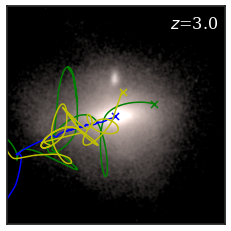

In [22]:
pig = BigFile('/hildafs/datasets/Asterix/PIG_files/PIG_214')
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
hh = battr['HubbleParam']
    
BH_IDs = pig.open('5/ID')[:]
lbt = pig.open('FOFGroups/LengthByType')[:]
OffsetByType = np.cumsum(lbt,axis=0)
a1 = np.array([[0,0,0,0,0,0]],dtype=np.uint64)
OffsetByType = np.append(a1,OffsetByType,axis=0)
bhoff = OffsetByType[:,5]

for triple in triples_z3_dr30[8:9]:
    f,ax = plt.subplots()
    f.subplots_adjust(hspace=0.03,wspace=0.03)
    
    plot_trip(ax,trip=triple,Lb=150,frame='COM')
    
    plt.savefig("z3_dr30_triple",dpi=150,bbox_inches='tight')

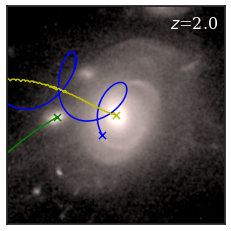

In [23]:
pig = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_348')
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
hh = battr['HubbleParam']
    
BH_IDs = pig.open('5/ID')[:]
lbt = pig.open('FOFGroups/LengthByType')[:]
OffsetByType = np.cumsum(lbt,axis=0)
a1 = np.array([[0,0,0,0,0,0]],dtype=np.uint64)
OffsetByType = np.append(a1,OffsetByType,axis=0)
bhoff = OffsetByType[:,5]

for triple in triples_z2_dr30[4:5]:
    f,ax = plt.subplots()
    f.subplots_adjust(hspace=0.03,wspace=0.03)
    
    plot_trip(ax,trip=triple,Lb=150,frame='COM')
    
    plt.savefig("z2_dr30_triple",dpi=150,bbox_inches='tight')

## Generating Images for 30 kpc Quadruples

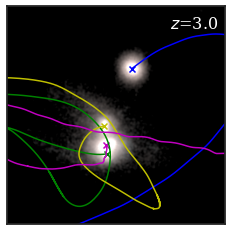

In [24]:
pig = BigFile('/hildafs/datasets/Asterix/PIG_files/PIG_214')
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
hh = battr['HubbleParam']
    
BH_IDs = pig.open('5/ID')[:]
lbt = pig.open('FOFGroups/LengthByType')[:]
OffsetByType = np.cumsum(lbt,axis=0)
a1 = np.array([[0,0,0,0,0,0]],dtype=np.uint64)
OffsetByType = np.append(a1,OffsetByType,axis=0)
bhoff = OffsetByType[:,5]

for quadruple in quadruples_z3_dr30[2:3]:
    f,ax = plt.subplots()
    f.subplots_adjust(hspace=0.03,wspace=0.03)
    
    plot_quad(ax,quad=quadruple,Lb=150,frame='COM')
    
    plt.savefig("z3_dr30_quadruple",dpi=150,bbox_inches='tight')

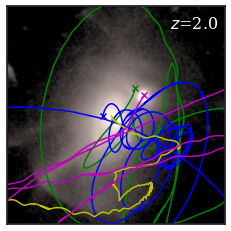

In [25]:
pig = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_348')
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
hh = battr['HubbleParam']
    
BH_IDs = pig.open('5/ID')[:]
lbt = pig.open('FOFGroups/LengthByType')[:]
OffsetByType = np.cumsum(lbt,axis=0)
a1 = np.array([[0,0,0,0,0,0]],dtype=np.uint64)
OffsetByType = np.append(a1,OffsetByType,axis=0)
bhoff = OffsetByType[:,5]

for quadruple in quadruples_z2_dr30[1:2]:
    f,ax = plt.subplots()
    f.subplots_adjust(hspace=0.03,wspace=0.03)
    
    plot_quad(ax,quad=quadruple,Lb=150,frame='COM')
    
    plt.savefig("z2_dr30_quadruple",dpi=150,bbox_inches='tight')

## Generating Images for 200 kpc Triples

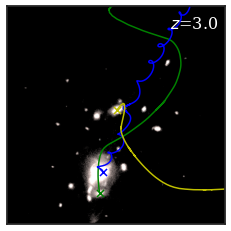

In [26]:
pig = BigFile('/hildafs/datasets/Asterix/PIG_files/PIG_214')
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
hh = battr['HubbleParam']
    
BH_IDs = pig.open('5/ID')[:]
lbt = pig.open('FOFGroups/LengthByType')[:]
OffsetByType = np.cumsum(lbt,axis=0)
a1 = np.array([[0,0,0,0,0,0]],dtype=np.uint64)
OffsetByType = np.append(a1,OffsetByType,axis=0)
bhoff = OffsetByType[:,5]

for triple in triples_z3_dr200[0:1]:
    f,ax = plt.subplots()
    f.subplots_adjust(hspace=0.03,wspace=0.03)
    
    plot_trip(ax,trip=triple,Lb=750,frame='COM')
    
    plt.savefig("z3_dr200_triple",dpi=150,bbox_inches='tight')

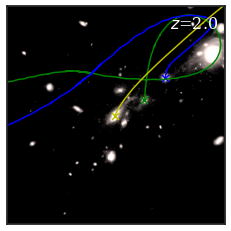

In [27]:
pig = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_348')
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
hh = battr['HubbleParam']
    
BH_IDs = pig.open('5/ID')[:]
lbt = pig.open('FOFGroups/LengthByType')[:]
OffsetByType = np.cumsum(lbt,axis=0)
a1 = np.array([[0,0,0,0,0,0]],dtype=np.uint64)
OffsetByType = np.append(a1,OffsetByType,axis=0)
bhoff = OffsetByType[:,5]

for triple in triples_z2_dr200[5:6]:
    f,ax = plt.subplots()
    f.subplots_adjust(hspace=0.03,wspace=0.03)
    
    plot_trip(ax,trip=triple,Lb=750,frame='COM')
    
    plt.savefig("z2_dr200_triple",dpi=150,bbox_inches='tight')

## Generating Images for 200 kpc Quadruples

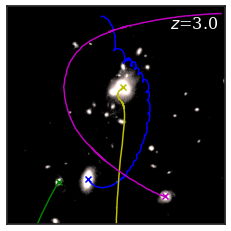

In [28]:
pig = BigFile('/hildafs/datasets/Asterix/PIG_files/PIG_214')
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
hh = battr['HubbleParam']
    
BH_IDs = pig.open('5/ID')[:]
lbt = pig.open('FOFGroups/LengthByType')[:]
OffsetByType = np.cumsum(lbt,axis=0)
a1 = np.array([[0,0,0,0,0,0]],dtype=np.uint64)
OffsetByType = np.append(a1,OffsetByType,axis=0)
bhoff = OffsetByType[:,5]

for quadruple in quadruples_z3_dr200[0:1]:
    f,ax = plt.subplots()
    f.subplots_adjust(hspace=0.03,wspace=0.03)
    
    plot_quad(ax,quad=quadruple,Lb=750,frame='COM')
    
    plt.savefig("z3_dr200_quadruple",dpi=150,bbox_inches='tight')

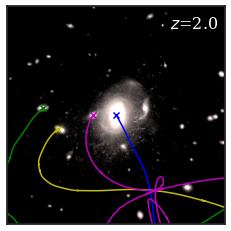

In [29]:
pig = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_348')
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
hh = battr['HubbleParam']
    
BH_IDs = pig.open('5/ID')[:]
lbt = pig.open('FOFGroups/LengthByType')[:]
OffsetByType = np.cumsum(lbt,axis=0)
a1 = np.array([[0,0,0,0,0,0]],dtype=np.uint64)
OffsetByType = np.append(a1,OffsetByType,axis=0)
bhoff = OffsetByType[:,5]

for quadruple in quadruples_z2_dr200[17:18]:
    f,ax = plt.subplots()
    f.subplots_adjust(hspace=0.03,wspace=0.03)
    
    plot_quad(ax,quad=quadruple,Lb=750,frame='COM')
    
    plt.savefig("z2_dr200_quadruple",dpi=150,bbox_inches='tight')

## Generating Evolution for 30 kpc Triples at z = 3.0

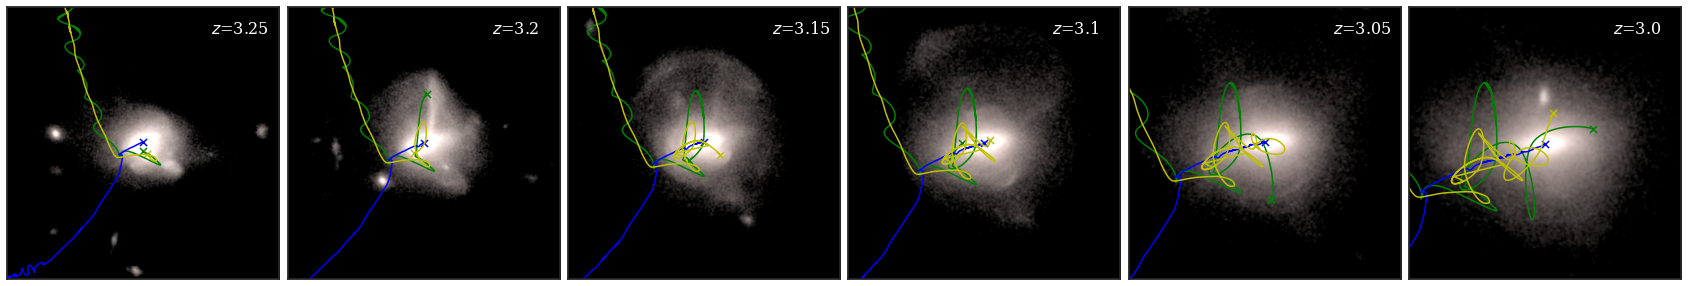

In [30]:
files = ['/hildafs/datasets/Asterix/PIG_files/PIG_190','/hildafs/datasets/Asterix/PIG_files/PIG_194',
         '/hildafs/datasets/Asterix/PIG_files/PIG_198','/hildafs/datasets/Asterix/PIG_files/PIG_202',
         '/hildafs/datasets/Asterix/PIG_files/PIG_207', '/hildafs/datasets/Asterix/PIG_files/PIG_214']

for triple in triples_z3_dr30[8:9]:
    f,axes = plt.subplots(1,len(files),figsize=(30,6))
    f.subplots_adjust(hspace=0.03,wspace=0.03)
    
    Lb = 275

    for k in range(0,len(files)):
        pig = BigFile(files[k])
        battr = pig["Header"].attrs
        scale_fac = battr["Time"][0]
        redshift = 1./battr["Time"][0] - 1
        hh = battr['HubbleParam']

        BH_IDs = pig.open('5/ID')[:1000000]
        lbt = pig.open('FOFGroups/LengthByType')[0:100000]
        OffsetByType = np.cumsum(lbt,axis=0)
        a1 = np.array([[0,0,0,0,0,0]],dtype=np.uint64)
        OffsetByType = np.append(a1,OffsetByType,axis=0)
        bhoff = OffsetByType[:,5]

        ax = axes.flat[k]

        plot_trip(ax,trip=triple,Lb=Lb,frame='COM')

        Lb -= 25
    
    plt.savefig("z3_dr30_triple_evolution",dpi=150,bbox_inches='tight')